# Latent Dirichlet Allocation

The purpose of applying the LDA method is to obtain the distribution of words that make up a topic and documents with a particular topic. The first stage in LDA modeling is to initialize the parameters. These parameters can be the number of documents, the number of words in the document, the number of topics, the number of iterations, and the LDA coefficient. The next stage is to mark a word with a predetermined topic by applying a semi-random distribution based on the Dirichlet distribution method. Next is the iteration stage. In this stage, there are parameters that can determine the distribution of the number of topics and the distribution of words from topics in a document.

## Dependencies

In [ ]:
!pip install google-cloud-bigquery
!pip install PySastrawi
!pip install nltk
!pip install pyLDAvis

In [ ]:
import pandas as pd
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
from string import punctuation
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from gensim.models.coherencemodel import CoherenceModel
import re
import pyLDAvis.gensim_models
import pickle
import numpy as np, pandas as pd

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


## Load Data

In [ ]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'future-data-track-1-sapporo.json'

In [ ]:
# Imports the Google Cloud client library
from google.cloud import bigquery

In [ ]:
# Instantiates a client for Bigquery Service
bigquery_client = bigquery.Client(project='future-data-track-1')

In [ ]:
# Query for BigQuery
QUERY = """
SELECT
  *
FROM
  `future-data-track-1.sapporo_staging.app_review`
LIMIT
  100
"""

In [ ]:
# Run the query and get data from BigQuery
query_job = bigquery_client.query(QUERY) # API request

In [ ]:
# Ture the data into pandas DataFrame
df = query_job.to_dataframe()

In [ ]:
# Show the result
df

,app_name,app_id,review_id,user_name,review,rating,app_version,created_date,platform,dag_execution_date,user_image,thumbs_up_count,reply,replied_at
0,bhinneka,bmd.android.apps,gp:AOqpTOGGWa6RFQpFCoh4rvkYSOGjzi_U5kjTaB_u7R4...,anis ridwan,"Woi balikin saldo saya 100k, trx gagal..",1,None,2020-10-15 13:15:47+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/a/AATXAJ...,2,None,NaT
1,bhinneka,bmd.android.apps,gp:AOqpTOHHowKgsa6Qrcsd4Vg4KhP4HQmxgJONLJPMSPk...,Anita,"Bayar pajak, kan aneh ya barang lokal",1,None,2020-08-18 13:45:18+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/a-/AOh14...,2,None,NaT
2,bhinneka,bmd.android.apps,gp:AOqpTOGw3IUB_EN1S98wBnKhZfUAPeugd85p33CzEg2...,Karya Muda Kaliasin KMK,"Sampah, isi alamat aja kaga muncul centang",1,None,2021-01-14 13:23:44+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/a-/AOh14...,5,None,NaT
3,bhinneka,bmd.android.apps,gp:AOqpTOEo5_rUfHashBdRLL-LaPcnUONdO_1SayFs6Hz...,Pengguna Google,parahhhhh,1,None,2019-01-31 11:26:23+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/EGemoI2N...,1,Mohon agar dapat menginformasikan kendala yang...,2019-02-27 07:28:38+00:00
4,bhinneka,bmd.android.apps,gp:AOqpTOH4t9180LrWw-MWpWNNvzd1JLXjAdllj-CZHVW...,Laila Ramadhani,Nyebelin banget d cari apa yang keluar apa tru...,1,None,2018-03-23 02:46:18+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/a/AATXAJ...,2,Mohon maaf atas ketidaknyamanannya. Terkait ke...,2018-04-04 04:13:57+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,bhinneka,bmd.android.apps,gp:AOqpTOGzFWfXFX4cnBFzxA4Rxzld8fO80cR0xX6tEct...,Pengguna Google,Mau beli tapi stok pada habis..,1,1.0.0.2010-production,2018-02-27 16:49:15+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/EGemoI2N...,1,None,NaT
96,bhinneka,bmd.android.apps,gp:AOqpTOFFpM07R6ep_tHAjxShBAL_f6X4JT00zTjXQ3l...,Pengguna Google,Saya daftar selalu tidak bisa tulisannya tidak...,1,1.0.0.2010-production,2018-01-24 03:01:41+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/EGemoI2N...,14,None,NaT
97,bhinneka,bmd.android.apps,gp:AOqpTOEi2jjdSTgV_QXDUMCG9aKFPIl81liesnTEvSB...,All Evy,"Aplikasi hidup segan mati tak mau,lebih baik d...",1,1.0.0.2010-production,2018-03-11 10:34:10+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/a-/AOh14...,2,None,NaT
98,bhinneka,bmd.android.apps,gp:AOqpTOFGmrv-bFg7XzurBmr2vMNESBpfv31-ak9sLKj...,Aldy Gallagher,"Udah 3 hari barang ga sampe sampe, padahal mas...",1,1.0.0.2010-production,2018-02-15 01:01:20+00:00,Play Store,2021-12-17 13:36:00+00:00,https://play-lh.googleusercontent.com/a-/AOh14...,3,None,NaT


In [ ]:
# Select columns

df_preprocess = df[['review', 'rating']]
df_preprocess

,review,rating
0,"Woi balikin saldo saya 100k, trx gagal..",1
1,"Bayar pajak, kan aneh ya barang lokal",1
2,"Sampah, isi alamat aja kaga muncul centang",1
3,parahhhhh,1
4,Nyebelin banget d cari apa yang keluar apa tru...,1
...,...,...
95,Mau beli tapi stok pada habis..,1
96,Saya daftar selalu tidak bisa tulisannya tidak...,1
97,"Aplikasi hidup segan mati tak mau,lebih baik d...",1
98,"Udah 3 hari barang ga sampe sampe, padahal mas...",1


## Preprocess

### Initial Stopwords

In [ ]:
# Extending Sastrawi StopWords

class ExtendStopWordRemoverFactory(StopWordRemoverFactory):
  def get_stop_word(self):
    new_sw = ["ada","adalah","adanya","adapun","agak","agaknya","agar","akan","akankah","akhir","akhiri","akhirnya","aku","akulah","amat","amatlah","anda","andalah","antar","antara","antaranya","apa","apaan","apabila","apakah","apalagi","apatah","artinya","asal","asalkan","atas","atau","ataukah","ataupun","awal","awalnya","bagai","bagaikan","bagaimana","bagaimanakah","bagaimanapun","bagi","bagian","bahkan","bahwa","bahwasanya","baik","bakal","bakalan","balik","banyak","bapak","baru","bawah","beberapa","begini","beginian","beginikah","beginilah","begitu","begitukah","begitulah","begitupun","bekerja","belakang","belakangan","belum","belumlah","benar","benarkah","benarlah","berada","berakhir","berakhirlah","berakhirnya","berapa","berapakah","berapalah","berapapun","berarti","berawal","berbagai","berdatangan","beri","berikan","berikut","berikutnya","berjumlah","berkali-kali","berkata","berkehendak","berkeinginan","berkenaan","berlainan","berlalu","berlangsung","berlebihan","bermacam","bermacam-macam","bermaksud","bermula","bersama","bersama-sama","bersiap","bersiap-siap","bertanya","bertanya-tanya","berturut","berturut-turut","bertutur","berujar","berupa","besar","betul","betulkah","biasa","biasanya","bila","bilakah","bisa","bisakah","boleh","bolehkah","bolehlah","buat","bukan","bukankah","bukanlah","bukannya","bulan","bung","cara","caranya","cukup","cukupkah","cukuplah","cuma","dahulu","dalam","dan","dapat","dari","daripada","datang","dekat","demi","demikian","demikianlah","dengan","depan","di","dia","diakhiri","diakhirinya","dialah","diantara","diantaranya","diberi","diberikan","diberikannya","dibuat","dibuatnya","didapat","didatangkan","digunakan","diibaratkan","diibaratkannya","diingat","diingatkan","diinginkan","dijawab","dijelaskan","dijelaskannya","dikarenakan","dikatakan","dikatakannya","dikerjakan","diketahui","diketahuinya","dikira","dilakukan","dilalui","dilihat","dimaksud","dimaksudkan","dimaksudkannya","dimaksudnya","diminta","dimintai","dimisalkan","dimulai","dimulailah","dimulainya","dimungkinkan","dini","dipastikan","diperbuat","diperbuatnya","dipergunakan","diperkirakan","diperlihatkan","diperlukan","diperlukannya","dipersoalkan","dipertanyakan","dipunyai","diri","dirinya","disampaikan","disebut","disebutkan","disebutkannya","disini","disinilah","ditambahkan","ditandaskan","ditanya","ditanyai","ditanyakan","ditegaskan","ditujukan","ditunjuk","ditunjuki","ditunjukkan","ditunjukkannya","ditunjuknya","dituturkan","dituturkannya","diucapkan","diucapkannya","diungkapkan","dong","dua","dulu","empat","enggak","enggaknya","entah","entahlah","guna","gunakan","hal","hampir","hanya","hanyalah","hari","harus","haruslah","harusnya","hendak","hendaklah","hendaknya","hingga","ia","ialah","ibarat","ibaratkan","ibaratnya","ibu","ikut","ingat","ingat-ingat","ingin","inginkah","inginkan","ini","inikah","inilah","itu","itukah","itulah","jadi","jadilah","jadinya","jangan","jangankan","janganlah","jauh","jawab","jawaban","jawabnya","jelas","jelaskan","jelaslah","jelasnya","jika","jikalau","juga","jumlah","jumlahnya","justru","kala","kalau","kalaulah","kalaupun","kalian","kami","kamilah","kamu","kamulah","kan","kapan","kapankah","kapanpun","karena","karenanya","kasus","kata","katakan","katakanlah","katanya","ke","keadaan","kebetulan","kecil","kedua","keduanya","keinginan","kelamaan","kelihatan","kelihatannya","kelima","keluar","kembali","kemudian","kemungkinan","kemungkinannya","kenapa","kepada","kepadanya","kesampaian","keseluruhan","keseluruhannya","keterlaluan","ketika","khususnya","kini","kinilah","kira","kira-kira","kiranya","kita","kitalah","kok","kurang","lagi","lagian","lah","lain","lainnya","lalu","lama","lamanya","lanjut","lanjutnya","lebih","lewat","lima","luar","macam","maka","makanya","makin","malah","malahan","mampu","mampukah","mana","manakala","manalagi","masa","masalah","masalahnya","masih","masihkah","masing","masing-masing","mau","maupun","melainkan","melakukan","melalui","melihat","melihatnya","memang","memastikan","memberi","memberikan","membuat","memerlukan","memihak","meminta","memintakan","memisalkan","memperbuat","mempergunakan","memperkirakan","memperlihatkan","mempersiapkan","mempersoalkan","mempertanyakan","mempunyai","memulai","memungkinkan","menaiki","menambahkan","menandaskan","menanti","menanti-nanti","menantikan","menanya","menanyai","menanyakan","mendapat","mendapatkan","mendatang","mendatangi","mendatangkan","menegaskan","mengakhiri","mengapa","mengatakan","mengatakannya","mengenai","mengerjakan","mengetahui","menggunakan","menghendaki","mengibaratkan","mengibaratkannya","mengingat","mengingatkan","menginginkan","mengira","mengucapkan","mengucapkannya","mengungkapkan","menjadi","menjawab","menjelaskan","menuju","menunjuk","menunjuki","menunjukkan","menunjuknya","menurut","menuturkan","menyampaikan","menyangkut","menyatakan","menyebutkan","menyeluruh","menyiapkan","merasa","mereka","merekalah","merupakan","meski","meskipun","meyakini","meyakinkan","minta","mirip","misal","misalkan","misalnya","mula","mulai","mulailah","mulanya","mungkin","mungkinkah","nah","naik","namun","nanti","nantinya","nyaris","nyatanya","oleh","olehnya","pada","padahal","padanya","pak","paling","panjang","pantas","para","pasti","pastilah","penting","pentingnya","per","percuma","perlu","perlukah","perlunya","pernah","persoalan","pertama","pertama-tama","pertanyaan","pertanyakan","pihak","pihaknya","pukul","pula","pun","punya","rasa","rasanya","rata","rupanya","saat","saatnya","saja","sajalah","saling","sama","sama-sama","sambil","sampai","sampai-sampai","sampaikan","sana","sangat","sangatlah","satu","saya","sayalah","se","sebab","sebabnya","sebagai","sebagaimana","sebagainya","sebagian","sebaik","sebaik-baiknya","sebaiknya","sebaliknya","sebanyak","sebegini","sebegitu","sebelum","sebelumnya","sebenarnya","seberapa","sebesar","sebetulnya","sebisanya","sebuah","sebut","sebutlah","sebutnya","secara","secukupnya","sedang","sedangkan","sedemikian","sedikit","sedikitnya","seenaknya","segala","segalanya","segera","seharusnya","sehingga","seingat","sejak","sejauh","sejenak","sejumlah","sekadar","sekadarnya","sekali","sekali-kali","sekalian","sekaligus","sekalipun","sekarang","sekarang","sekecil","seketika","sekiranya","sekitar","sekitarnya","sekurang-kurangnya","sekurangnya","sela","selain","selaku","selalu","selama","selama-lamanya","selamanya","selanjutnya","seluruh","seluruhnya","semacam","semakin","semampu","semampunya","semasa","semasih","semata","semata-mata","semaunya","sementara","semisal","semisalnya","sempat","semua","semuanya","semula","sendiri","sendirian","sendirinya","seolah","seolah-olah","seorang","sepanjang","sepantasnya","sepantasnyalah","seperlunya","seperti","sepertinya","sepihak","sering","seringnya","serta","serupa","sesaat","sesama","sesampai","sesegera","sesekali","seseorang","sesuatu","sesuatunya","sesudah","sesudahnya","setelah","setempat","setengah","seterusnya","setiap","setiba","setibanya","setidak-tidaknya","setidaknya","setinggi","seusai","sewaktu","siap","siapa","siapakah","siapapun","sini","sinilah","soal","soalnya","suatu","sudah","sudahkah","sudahlah","supaya","tadi","tadinya","tahu","tahun","tak","tambah","tambahnya","tampak","tampaknya","tandas","tandasnya","tanpa","tanya","tanyakan","tanyanya","tapi","tegas","tegasnya","telah","tempat","tengah","tentang","tentu","tentulah","tentunya","tepat","terakhir","terasa","terbanyak","terdahulu","terdapat","terdiri","terhadap","terhadapnya","teringat","teringat-ingat","terjadi","terjadilah","terjadinya","terkira","terlalu","terlebih","terlihat","termasuk","ternyata","tersampaikan","tersebut","tersebutlah","tertentu","tertuju","terus","terutama","tetap","tetapi","tiap","tiba","tiba-tiba","tidak","tidakkah","tidaklah","tiga","tinggi","toh","tunjuk","turut","tutur","tuturnya","ucap","ucapnya","ujar","ujarnya","umum","umumnya","ungkap","ungkapnya","untuk","usah","usai","waduh","wah","wahai","waktu","waktunya","walau","walaupun","wong","yaitu","yakin","yakni","yang"]
    new_sw.extend(super().get_stop_words())
    return list(set(new_sw))

In [ ]:
sw_remover = ExtendStopWordRemoverFactory().create_stop_word_remover()

### Initial Stemming

using sastrawi

In [ ]:
# Create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

### Initial Formalization

In [ ]:
formalization_indo = {"@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

In [ ]:
formalization_indo

{'@': 'di',
 'abis': 'habis',
 'ad': 'ada',
 'adlh': 'adalah',
 'afaik': 'as far as i know',
 'ahaha': 'haha',
 'aj': 'saja',
 'ajep-ajep': 'dunia gemerlap',
 'ak': 'saya',
 'akika': 'aku',
 'akkoh': 'aku',
 'akuwh': 'aku',
 'alay': 'norak',
 'alow': 'halo',
 'ambilin': 'ambilkan',
 'ancur': 'hancur',
 'anjrit': 'anjing',
 'anter': 'antar',
 'ap2': 'apa-apa',
 'apasih': 'apa sih',
 'apes': 'sial',
 'aps': 'apa',
 'aq': 'saya',
 'aquwh': 'aku',
 'asbun': 'asal bunyi',
 'aseekk': 'asyik',
 'asekk': 'asyik',
 'asem': 'asam',
 'aspal': 'asli tetapi palsu',
 'astul': 'asal tulis',
 'ato': 'atau',
 'au ah': 'tidak mau tahu',
 'awak': 'saya',
 'ay': 'sayang',
 'ayank': 'sayang',
 'b4': 'sebelum',
 'bakalan': 'akan',
 'bandes': 'bantuan desa',
 'bangedh': 'banget',
 'banpol': 'bantuan polisi',
 'banpur': 'bantuan tempur',
 'basbang': 'basi',
 'bcanda': 'bercanda',
 'bdg': 'bandung',
 'begajulan': 'nakal',
 'beliin': 'belikan',
 'bencong': 'banci',
 'bentar': 'sebentar',
 'ber3': 'bertiga',
 'b

In [ ]:
random_state = 0

### Initial Token

In [ ]:
# list for tokenized documents in loop
texts = []

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

### Preprocess

This process include casefolding, remove special character, multiple whitespace, stopword, and stemming

In [ ]:
def preprocess(value, sw_remover):
  value = value.lower()
  value = re.sub(r'[^a-zA-Z]', ' ', value)
  value = re.sub(r'\s\s+', ' ', value)
  value = stemmer.stem(value)
  value = sw_remover.remove(value)
  return value

In [ ]:
processed_values = df_preprocess['review'].apply(lambda x: preprocess(x, sw_remover))
processed_values = processed_values.replace('', float("NaN"))
df_token = df_preprocess.copy()
df_token['review'] = processed_values

In [ ]:
df_token

,review,rating
0,woi balikin saldo trx gagal,1
1,bayar pajak aneh barang lokal,1
2,sampah isi alamat aja kaga muncul centang,1
3,parahhhhh,1
4,nyebelin banget cari trus barang pilih aja,1
...,...,...
95,beli stok habis,1
96,daftar tulis koneksi internet coba hape browsi...,1
97,aplikasi hidup segan mati delcon aja bye,1
98,udah barang ga sampe sampe region tolong respo...,1


### Tokenization

In [ ]:
# Tokenize
for i in df_token['review']:
  tokens = tokenizer.tokenize(i)
  texts.append(tokens)

### Formalization

In [ ]:
def convert(l, d):
  return [convert(x, d) if isinstance(x, list) else d.get(x, x) for x in l]

In [ ]:
texts = convert(texts, formalization_indo)

In [ ]:
texts

[['woi', 'balikin', 'saldo', 'trx', 'gagal'],
 ['bayar', 'pajak', 'aneh', 'barang', 'lokal'],
 ['sampah', 'isi', 'alamat', 'saja', 'tidak', 'muncul', 'centang'],
 ['parahhhhh'],
 ['nyebelin', 'banget', 'cari', 'trus', 'barang', 'pilih', 'saja'],
 ['tolong',
  'refund',
  'uang',
  'ktp',
  'woy',
  'tinggal',
  'balikin',
  'nomer',
  'yang',
  'trf'],
 ['kalau',
  'emg',
  'aplikasi',
  'niat',
  'ngebantuin',
  'kredit',
  'gausah',
  'peribet',
  'udh',
  'terlanjur',
  'males',
  'delu',
  'org',
  'gadak',
  'faedah',
  'huhh'],
 ['instal',
  'apk',
  'fedback',
  'jelek',
  'yang',
  'koment',
  'ga',
  'akh',
  'takuuut',
  'nanti',
  'ketipuuuuh'],
 ['yang',
  'bilang',
  'register',
  'saya',
  'sdh',
  'gmail',
  'password',
  'jenis',
  'kelamin',
  'no',
  'hp',
  'tanggal',
  'lahir',
  'login',
  'bilang',
  'email',
  'password',
  'salah',
  'yang',
  'salah',
  'org',
  'it',
  'sih',
  'jangan',
  'coba',
  'tipu',
  'masyarakat',
  'indonesia'],
 ['install',
  'trans

## Modelling

In [ ]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

In [ ]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]
for k in range (5, 6):
  # generate LDA model
  ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=k, id2word = dictionary, passes=20, iterations=100, alpha=[0.01]*k, eta=[0.01]*len(dictionary.keys()))
  # print(ldamodel.show_topics())
  # compute coherence score
  coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  # print(k, ldamodel.log_perplexity(corpus),coherence_lda)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

5 -7.448139925012796 0.3850878464681732


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
print(k, ldamodel.log_perplexity(corpus),coherence_lda)

5 -7.448139930822355 0.3850878464681732


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
  # Init output
  sent_topics_df = pd.DataFrame()

  # Get main topic in each document
  for i, row_list in enumerate(ldamodel[corpus]):
    row = row_list[0] if ldamodel.per_word_topics else row_list
    print(row)
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
      if j == 0:
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
      else:
        break
  sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

  # Add original text to the end of the output
  contents = pd.Series(texts)
  sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
  return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=texts)

[(1, 0.9920792)]
[(1, 0.9920792)]
[(3, 0.99432623)]
[(2, 0.9619048)]
[(1, 0.99432623)]
[(2, 0.9960199)]
[(1, 0.99750775)]
[(0, 0.9963801)]
[(1, 0.99857396)]
[(1, 0.13279746), (4, 0.86600494)]
[(4, 0.99558014)]
[(3, 0.9969349)]
[(1, 0.99012345)]
[(2, 0.99432623)]
[(0, 0.99558014)]
[(0, 0.99936557)]
[(1, 0.99012345)]
[(2, 0.9976539)]
[(2, 0.99558014)]
[(4, 0.99558014)]
[(0, 0.99432623)]
[(3, 0.9920792)]
[(0, 0.9804878)]
[(3, 0.99809974)]
[(4, 0.9804878)]
[(0, 0.9920792)]
[(3, 0.99432623)]
[(2, 0.9804878)]
[(3, 0.98688525)]
[(3, 0.99503106)]
[(1, 0.9920792)]
[(0, 0.64408636), (4, 0.34850624)]
[(3, 0.9920792)]
[(2, 0.99432623)]
[(1, 0.9920792)]
[(4, 0.9960199)]
[(2, 0.98688525)]
[(2, 0.99503106)]
[(1, 0.99012345)]
[(3, 0.9804878)]
[(0, 0.9980049)]
[(1, 0.99558014)]
[(2, 0.99846447)]
[(4, 0.9933884)]
[(3, 0.9619048)]
[(2, 0.99734217)]
[(4, 0.9980049)]
[(0, 0.99432623)]
[(2, 0.9619048)]
[(3, 0.9920792)]
[(2, 0.9933884)]
[(4, 0.99558014)]
[(4, 0.9920792)]
[(4, 0.9977839)]
[(0, 0.99734217)]
[(

In [ ]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
print(df_dominant_topic.head(10))

   Document_No  ...                                               Text
0            0  ...                  [woi, balikin, saldo, trx, gagal]
1            1  ...                [bayar, pajak, aneh, barang, lokal]
2            2  ...  [sampah, isi, alamat, saja, tidak, muncul, cen...
3            3  ...                                        [parahhhhh]
4            4  ...  [nyebelin, banget, cari, trus, barang, pilih, ...
5            5  ...  [tolong, refund, uang, ktp, woy, tinggal, bali...
6            6  ...  [kalau, emg, aplikasi, niat, ngebantuin, kredi...
7            7  ...  [instal, apk, fedback, jelek, yang, koment, ga...
8            8  ...  [yang, bilang, register, saya, sdh, gmail, pas...
9            9  ...  [install, transaksi, app, pikir, semalem, isi,...

[10 rows x 5 columns]


In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
  corpus_sel = corpus[start:end]
  dominant_topics = []
  topic_percentages = []
  for i, corp in enumerate(corpus_sel):
    topic_percs = model[corp]
    dominant_topic = sorted(topic_percs, key = lambda x:x[1], reverse=True)[0][0]
    dominant_topics.append((i, dominant_topic))
    topic_percentages.append(topic_percs)
  return(dominant_topics, topic_percentages)

In [ ]:
dominant_topics, topic_percentages = topics_per_document(model=ldamodel, corpus=corpus, start=0, end=4)

In [ ]:
# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])

dominant_topic_in_each_doc = df_dominant_topic.groupby('Dominant_Topic').size()
print(dominant_topic_in_each_doc)
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

Dominant_Topic
0.0    14
1.0    23
2.0    22
3.0    17
4.0    24
dtype: int64


In [ ]:
# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

In [ ]:
# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in ldamodel.show_topics(formatted=False)for j, (topic, wt) in enumerate(topics) if j < 3]
df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(',\n'.join)
df_top3words.reset_index(level=0,inplace=True)

## Visualize

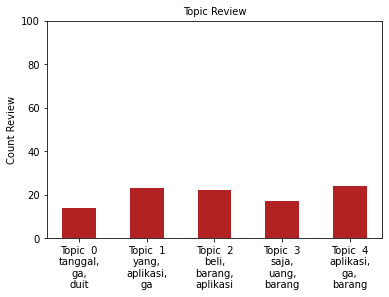

In [ ]:
fig, ax1 = plt.subplots()

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', 
        data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x,pos: 'Topic  ' + str(x)+'\n'+ df_top3words.loc[df_top3words.topic_id==x,'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Topic Review', fontdict=dict(size=10))
ax1.set_ylabel('Count Review')
ax1.set_ylim(0,100)

plt.show()